# Colab 시작 페이지

In [1]:
"""
Assignment 1: Neural Networks (IMDB)
- Run controlled experiments by changing:
  1) number of hidden layers (1 vs 2 vs 3)
  2) hidden units (32, 64, 128, ...)
  3) loss function (binary_crossentropy vs mse)
  4) activation (relu vs tanh)
  5) regularization techniques (dropout, L2, etc.)
- Summarize results in a table/graph and state conclusions.

This script:
1) loads IMDB data
2) vectorizes reviews (one-hot / multi-hot)
3) runs a grid of experiments
4) saves results to CSV + plots learning curves for the best model
"""

import os
import json
import math
import random
from dataclasses import dataclass, asdict
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers




SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# 1) Config

OUT_DIR = "assignment1_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

VOCAB_SIZE = 10000
TRAIN_VAL_SPLIT = 10000
BATCH_SIZE = 512
MAX_EPOCHS = 30


# 2) Load + Vectorize IMDB

def vectorize_sequences(sequences: List[List[int]], dimension: int) -> np.ndarray:
    """
    Convert list-of-word-indices into a 2D multi-hot matrix.
    Each row i is a review; each column j indicates whether word j appeared.
    """
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, seq in enumerate(sequences):

        for idx in seq:
            if 0 <= idx < dimension:
                results[i, idx] = 1.0
    return results


(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

x_train_full = vectorize_sequences(train_data, VOCAB_SIZE)
y_train_full = np.asarray(train_labels).astype("float32")

x_test = vectorize_sequences(test_data, VOCAB_SIZE)
y_test = np.asarray(test_labels).astype("float32")


x_val = x_train_full[:TRAIN_VAL_SPLIT]
partial_x_train = x_train_full[TRAIN_VAL_SPLIT:]

y_val = y_train_full[:TRAIN_VAL_SPLIT]
partial_y_train = y_train_full[TRAIN_VAL_SPLIT:]

print("Shapes:")
print("partial_x_train:", partial_x_train.shape, "partial_y_train:", partial_y_train.shape)
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)


# 3) Model builder

@dataclass
class ExperimentConfig:
    n_hidden_layers: int
    units: int
    activation: str
    loss: str
    dropout_rate: float
    l2_lambda: float
    learning_rate: float

def build_model(cfg: ExperimentConfig) -> keras.Model:
    """
    Build a simple feedforward network for IMDB multi-hot input.
    Output is sigmoid for binary classification.
    """
    reg = regularizers.l2(cfg.l2_lambda) if cfg.l2_lambda > 0 else None

    model = keras.Sequential()
    model.add(layers.Input(shape=(VOCAB_SIZE,)))


    for _ in range(cfg.n_hidden_layers):
        model.add(layers.Dense(cfg.units, activation=cfg.activation, kernel_regularizer=reg))
        if cfg.dropout_rate > 0:
            model.add(layers.Dropout(cfg.dropout_rate))


    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=cfg.learning_rate)


    model.compile(optimizer=optimizer, loss=cfg.loss, metrics=["accuracy"])
    return model


# 4) Training/eval routine

def run_experiment(cfg: ExperimentConfig) -> Dict[str, Any]:
    """
    Train with early stopping on validation loss.
    Return a flat dict with final/best metrics and where artifacts saved.
    """
    model = build_model(cfg)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        partial_x_train, partial_y_train,
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=0
    )


    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)


    best_epoch_idx = int(np.argmin(history.history["val_loss"]))
    best_val_loss_in_history = float(np.min(history.history["val_loss"]))
    best_val_acc_in_history = float(history.history["val_accuracy"][best_epoch_idx])

    result = {
        **asdict(cfg),
        "epochs_ran": len(history.history["loss"]),
        "best_epoch_by_val_loss": best_epoch_idx + 1,
        "best_val_loss_in_history": best_val_loss_in_history,
        "best_val_acc_in_history": best_val_acc_in_history,
        "val_loss_final_eval": float(val_loss),
        "val_acc_final_eval": float(val_acc),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
    }

    return result, history


# 5) Experiment grid


grid: List[ExperimentConfig] = []

for n_layers in [1, 2, 3]:
    for units in [32, 64, 128]:
        for activation in ["relu", "tanh"]:
            for loss in ["binary_crossentropy", "mse"]:
                for dropout_rate in [0.0, 0.2, 0.5]:
                    for l2_lambda in [0.0, 1e-4]:
                        grid.append(
                            ExperimentConfig(
                                n_hidden_layers=n_layers,
                                units=units,
                                activation=activation,
                                loss=loss,
                                dropout_rate=dropout_rate,
                                l2_lambda=l2_lambda,
                                learning_rate=1e-3
                            )
                        )

print(f"Total experiments: {len(grid)}")


# 6) Run all experiments + save results

all_results: List[Dict[str, Any]] = []
histories: Dict[int, Dict[str, Any]] = {}

for i, cfg in enumerate(grid, start=1):
    res, hist = run_experiment(cfg)
    all_results.append(res)


    if i % 10 == 0:
        print(f"Completed {i}/{len(grid)}")

results_df = pd.DataFrame(all_results)


results_df = results_df.sort_values(
    by=["val_acc_final_eval", "val_loss_final_eval"],
    ascending=[False, True]
).reset_index(drop=True)

results_csv_path = os.path.join(OUT_DIR, "results.csv")
results_df.to_csv(results_csv_path, index=False)
print("Saved:", results_csv_path)


# 7) Pick best config + retrain once more to plot curves cleanly

best_row = results_df.iloc[0].to_dict()
best_cfg = ExperimentConfig(
    n_hidden_layers=int(best_row["n_hidden_layers"]),
    units=int(best_row["units"]),
    activation=str(best_row["activation"]),
    loss=str(best_row["loss"]),
    dropout_rate=float(best_row["dropout_rate"]),
    l2_lambda=float(best_row["l2_lambda"]),
    learning_rate=float(best_row["learning_rate"]),
)

print("\nBest config by validation performance:")
print(best_cfg)


best_result, best_history = run_experiment(best_cfg)


best_json_path = os.path.join(OUT_DIR, "best_config_and_result.json")
with open(best_json_path, "w", encoding="utf-8") as f:
    json.dump({"best_config": asdict(best_cfg), "best_result": best_result}, f, indent=2)
print("Saved:", best_json_path)


# 8) Plot learning curves (validation accuracy + loss)

def plot_history(history: keras.callbacks.History, prefix: str):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)


    plt.figure()
    plt.plot(list(epochs), hist["accuracy"], label="train_acc")
    plt.plot(list(epochs), hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy (Train vs Validation)")
    plt.legend()
    acc_path = os.path.join(OUT_DIR, f"{prefix}_accuracy.png")
    plt.savefig(acc_path, dpi=200, bbox_inches="tight")
    plt.close()


    plt.figure()
    plt.plot(list(epochs), hist["loss"], label="train_loss")
    plt.plot(list(epochs), hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss (Train vs Validation)")
    plt.legend()
    loss_path = os.path.join(OUT_DIR, f"{prefix}_loss.png")
    plt.savefig(loss_path, dpi=200, bbox_inches="tight")
    plt.close()

    return acc_path, loss_path

acc_path, loss_path = plot_history(best_history, prefix="best_model")
print("Saved plots:", acc_path, loss_path)


# 9) Aggregate summaries

summary_by_layers = results_df.groupby("n_hidden_layers")[["val_acc_final_eval", "test_acc"]].mean().reset_index()
summary_by_layers_path = os.path.join(OUT_DIR, "summary_by_layers.csv")
summary_by_layers.to_csv(summary_by_layers_path, index=False)

summary_by_loss = results_df.groupby("loss")[["val_acc_final_eval", "test_acc"]].mean().reset_index()
summary_by_loss_path = os.path.join(OUT_DIR, "summary_by_loss.csv")
summary_by_loss.to_csv(summary_by_loss_path, index=False)

print("Saved:", summary_by_layers_path)
print("Saved:", summary_by_loss_path)


# 10) Print final headline numbers

print("\n=== BEST MODEL EVALUATION ===")
print("Validation accuracy:", best_result["val_acc_final_eval"])
print("Test accuracy:", best_result["test_acc"])

print("\nTop 10 results (validation acc):")
print(results_df.head(10)[
    ["n_hidden_layers","units","activation","loss","dropout_rate","l2_lambda","epochs_ran","val_acc_final_eval","test_acc"]
])


Shapes:
partial_x_train: (15000, 10000) partial_y_train: (15000,)
x_val: (10000, 10000) y_val: (10000,)
x_test: (25000, 10000) y_test: (25000,)
Total experiments: 216
Completed 10/216
Completed 20/216
Completed 30/216
Completed 40/216
Completed 50/216
Completed 60/216
Completed 70/216
Completed 80/216
Completed 90/216
Completed 100/216
Completed 110/216
Completed 120/216
Completed 130/216
Completed 140/216
Completed 150/216
Completed 160/216
Completed 170/216
Completed 180/216
Completed 190/216
Completed 200/216
Completed 210/216
Saved: assignment1_outputs/results.csv

Best config by validation performance:
ExperimentConfig(n_hidden_layers=2, units=64, activation='relu', loss='binary_crossentropy', dropout_rate=0.5, l2_lambda=0.0, learning_rate=0.001)
Saved: assignment1_outputs/best_config_and_result.json
Saved plots: assignment1_outputs/best_model_accuracy.png assignment1_outputs/best_model_loss.png
Saved: assignment1_outputs/summary_by_layers.csv
Saved: assignment1_outputs/summary_by

In [7]:
import pandas as pd
from IPython.display import display, Markdown

RESULTS_PATH = "/content/assignment1_outputs/results.csv"
df = pd.read_csv(RESULTS_PATH)

display(Markdown("### Table 1. Top 10 Hyperparameter Configurations (Ranked by Validation Accuracy)"))


cols = [
    "n_hidden_layers",
    "units",
    "activation",
    "loss",
    "dropout_rate",
    "l2_lambda",
    "epochs_ran",
    "val_acc_final_eval",
    "val_loss_final_eval",
    "test_acc"
]

top10 = df[cols].sort_values(
    by=["val_acc_final_eval", "val_loss_final_eval"],
    ascending=[False, True]
).head(10).copy()

top10 = top10.rename(columns={
    "n_hidden_layers": "Hidden Layers",
    "units": "Units",
    "activation": "Activation",
    "loss": "Loss Function",
    "dropout_rate": "Dropout",
    "l2_lambda": "L2",
    "epochs_ran": "Epochs",
    "val_acc_final_eval": "Validation Acc",
    "test_acc": "Test Acc"
})

top10["Dropout"] = top10["Dropout"].map(lambda x: f"{x:.1f}")
top10["L2"] = top10["L2"].map(lambda x: f"{x:.4g}")
top10["Validation Acc"] = top10["Validation Acc"].map(lambda x: f"{x:.4f}")
top10["Test Acc"] = top10["Test Acc"].map(lambda x: f"{x:.4f}")

top10.insert(0, "Rank", range(1, len(top10) + 1))


display(top10.drop(columns=["val_loss_final_eval"]))

def summarize_by(col: str) -> pd.DataFrame:
    out = (
        df.groupby(col)
          .agg(
              avg_val_acc=("val_acc_final_eval", "mean"),
              avg_test_acc=("test_acc", "mean"),
              n_runs=("val_acc_final_eval", "count"),
          )
          .reset_index()
          .sort_values("avg_val_acc", ascending=False)
    )
    return out

display(Markdown("### Table 2. Average Performance by Number of Hidden Layers"))
display(summarize_by("n_hidden_layers"))

display(Markdown("### Table 3. Average Performance by Loss Function"))
display(summarize_by("loss"))

display(Markdown("### Table 4. Average Performance by Activation Function"))
display(summarize_by("activation"))

display(Markdown("### Table 5. Average Performance by Dropout Rate"))
display(summarize_by("dropout_rate"))

### Table 1. Top 10 Hyperparameter Configurations (Ranked by Validation Accuracy)

,Rank,Hidden Layers,Units,Activation,Loss Function,Dropout,L2,Epochs,Validation Acc,Test Acc
0,1,2,64,relu,binary_crossentropy,0.5,0,6,0.8927,0.8810
1,2,3,32,relu,binary_crossentropy,0.0,0.0001,5,0.8919,0.8822
2,3,2,32,relu,binary_crossentropy,0.5,0.0001,7,0.8912,0.8852
3,4,1,64,relu,mse,0.5,0,7,0.8911,0.8826
4,5,2,32,relu,mse,0.5,0,7,0.8909,0.8843
5,6,1,32,relu,binary_crossentropy,0.5,0.0001,8,0.8906,0.8843
6,7,2,64,relu,mse,0.5,0,6,0.8905,0.8849
7,8,1,64,relu,mse,0.2,0.0001,6,0.8904,0.8820
8,9,1,64,tanh,binary_crossentropy,0.5,0.0001,6,0.8904,0.8819
9,10,2,32,relu,mse,0.2,0,6,0.8903,0.8828


### Table 2. Average Performance by Number of Hidden Layers

,n_hidden_layers,avg_val_acc,avg_test_acc,n_runs
0,1,0.887139,0.879638,72
1,2,0.886231,0.878788,72
2,3,0.885389,0.878861,72


### Table 3. Average Performance by Loss Function

,loss,avg_val_acc,avg_test_acc,n_runs
0,binary_crossentropy,0.886470,0.878940,108
1,mse,0.886035,0.879251,108


### Table 4. Average Performance by Activation Function

,activation,avg_val_acc,avg_test_acc,n_runs
0,relu,0.887013,0.879910,108
1,tanh,0.885493,0.878281,108


### Table 5. Average Performance by Dropout Rate

,dropout_rate,avg_val_acc,avg_test_acc,n_runs
2,0.5,0.887585,0.880826,72
1,0.2,0.885921,0.878379,72
0,0.0,0.885253,0.878081,72


### Output folder: `/content/assignment1_outputs`

Files:
 - best_config_and_result.json
 - best_model_accuracy.png
 - best_model_loss.png
 - results.csv
 - summary_by_layers.csv
 - summary_by_loss.csv


### Figures

**best_model_accuracy.png**

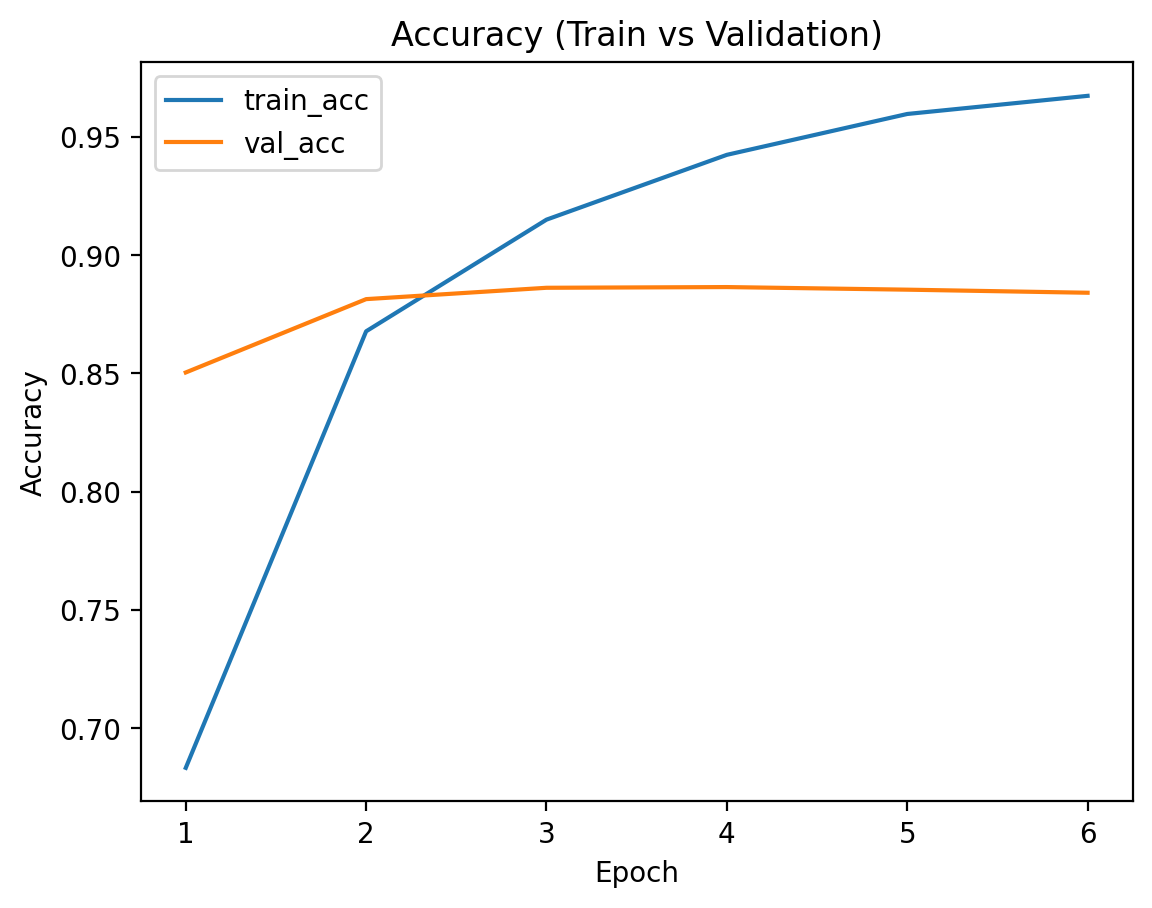

**best_model_loss.png**

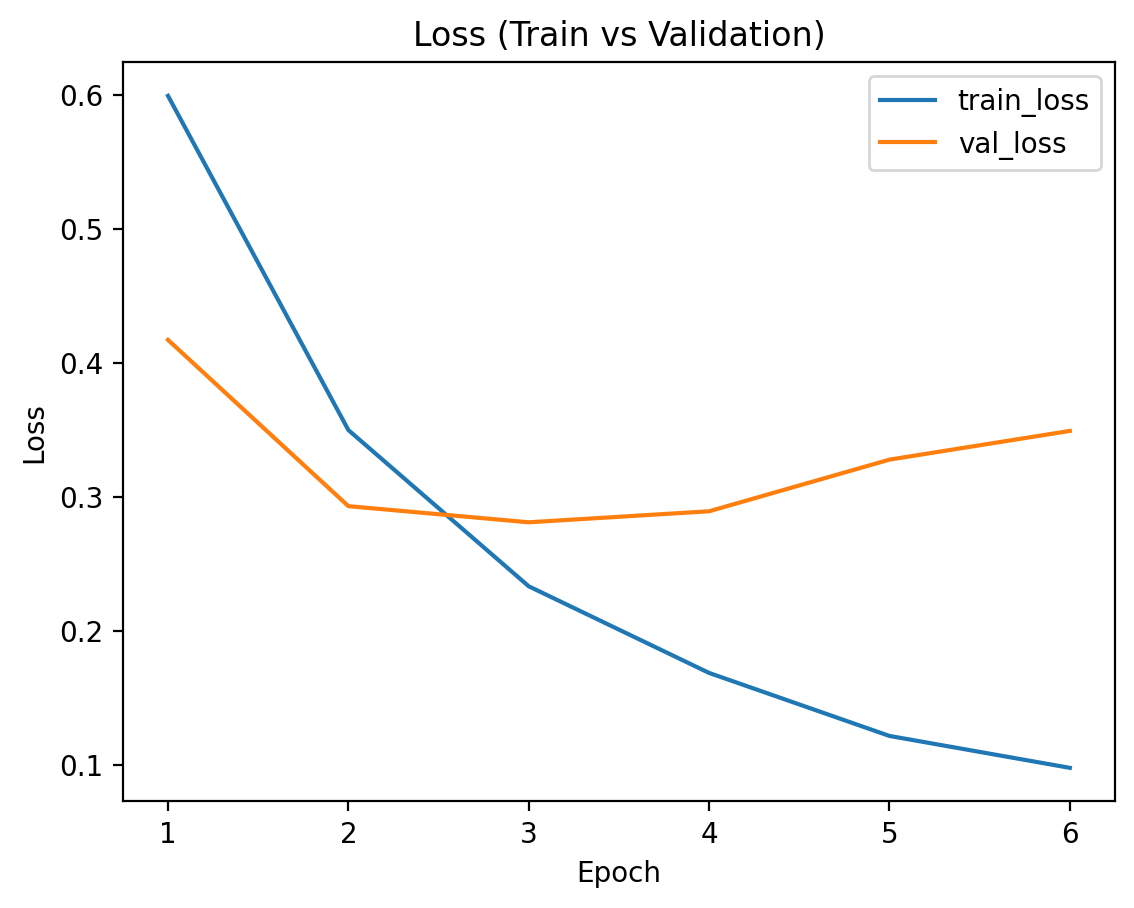

In [3]:
import os
from IPython.display import Image, display, Markdown

OUT_DIR = "assignment1_outputs"
out_path = f"/content/{OUT_DIR}" if os.path.exists("/content") else OUT_DIR


display(Markdown(f"### Output folder: `{out_path}`"))
if not os.path.exists(out_path):
    raise FileNotFoundError(f"Output folder not found: {out_path}")

files = sorted(os.listdir(out_path))
print("Files:")
for f in files:
    print(" -", f)


figs = [
    "best_model_accuracy.png",
    "best_model_loss.png",
]

display(Markdown("### Figures"))
for fname in figs:
    fpath = os.path.join(out_path, fname)
    if os.path.exists(fpath):
        display(Markdown(f"**{fname}**"))
        display(Image(filename=fpath))
    else:
        display(Markdown(f"- `{fname}` not found."))


other_pngs = [f for f in files if f.lower().endswith(".png") and f not in figs]
if other_pngs:
    display(Markdown("### Other PNG files"))
    for fname in other_pngs:
        fpath = os.path.join(out_path, fname)
        display(Markdown(f"**{fname}**"))
        display(Image(filename=fpath))


Across all experiments, models with ReLU activation and binary cross-entropy loss consistently outperformed alternatives such as tanh activation and mean squared error loss. The best-performing configuration consisted of two hidden layers with 64 units per layer and a dropout rate of 0.5, achieving a validation accuracy of approximately 0.89 and a test accuracy of approximately 0.88. Learning curves for the selected model indicate that training accuracy increases steadily while validation performance plateaus early, suggesting limited overfitting and effective use of early stopping. Overall, these results demonstrate that moderate model depth combined with appropriate regularization yields the best balance between predictive performance and generalization for the IMDB classification problem.
